In [77]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
from sklearn import linear_model
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

In [78]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices',con=engine)
engine.dispose()
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [79]:
dummies = pd.get_dummies(house_df[['mszoning', 'street', 'lotshape', 'utilities', 'salecondition']])
dummies['saleprice'] = house_df['saleprice']
dummies.corr()['saleprice']

mszoning_C (all)        -0.111257
mszoning_FV              0.089950
mszoning_RH             -0.065429
mszoning_RL              0.245063
mszoning_RM             -0.288065
street_Grvl             -0.041036
street_Pave              0.041036
lotshape_IR1             0.223284
lotshape_IR2             0.126096
lotshape_IR3             0.036720
lotshape_Reg            -0.267672
utilities_AllPub         0.014314
utilities_NoSeWa        -0.014314
salecondition_Abnorml   -0.118069
salecondition_AdjLand   -0.050686
salecondition_Alloca    -0.015525
salecondition_Family    -0.046480
salecondition_Normal    -0.153990
salecondition_Partial    0.352060
saleprice                1.000000
Name: saleprice, dtype: float64

In [80]:
100*house_df.isnull().sum()/house_df.isnull().count()

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
                   ...    
bedroomabvgr      0.000000
kitchenabvgr      0.000000
kitchenqual       0.000000
totrmsabvgrd      0.000000
functional        0.000000
fireplaces        0.000000
f

lotarea


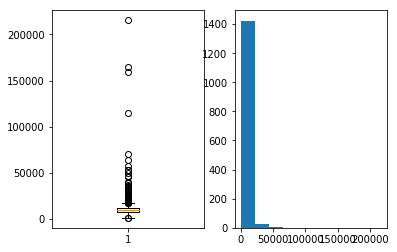

overallqual


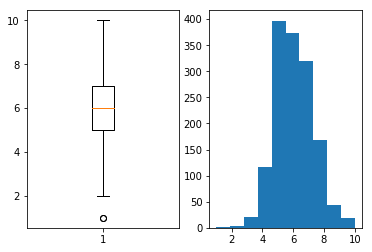

grlivarea


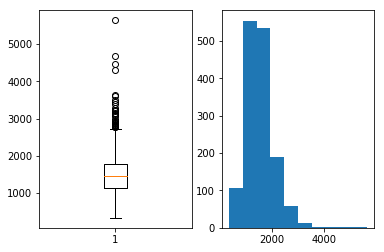

totalbsmtsf


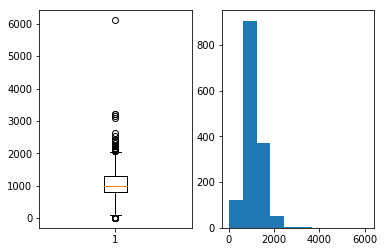

firstflrsf


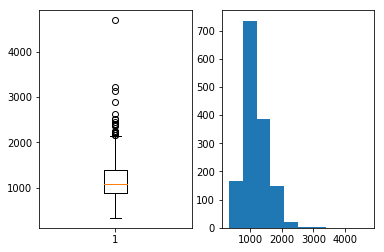

garagecars


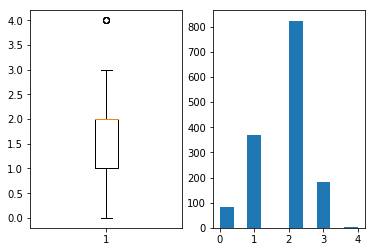

saleprice


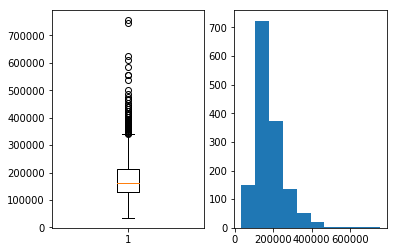

In [81]:
columns = ['lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'saleprice']
for col in columns:
    print(col)
    plt.subplot(1,2,1)
    plt.boxplot(house_df[col])
    plt.subplot(1,2,2)
    plt.hist(house_df[col])
    plt.show()

In [82]:
for col in columns:
    std = np.std(house_df[col])
    mean = np.mean(house_df[col])
    for i in range(len(house_df[col])):
        if i in house_df.index:
            if(house_df[col][i] >= mean + 3*std):
                house_df = house_df.loc[house_df.index != i]
                print('dropping value at {} because of {}'.format(i, col))
            elif(house_df[col][i] <= mean - 3*std):
                house_df = house_df.loc[house_df.index != i]
                print('dropping value at {} because of {}'.format(i, col))

dropping value at 53 because of lotarea
dropping value at 250 because of lotarea
dropping value at 314 because of lotarea
dropping value at 336 because of lotarea
dropping value at 385 because of lotarea
dropping value at 452 because of lotarea
dropping value at 458 because of lotarea
dropping value at 661 because of lotarea
dropping value at 706 because of lotarea
dropping value at 769 because of lotarea
dropping value at 848 because of lotarea
dropping value at 1298 because of lotarea
dropping value at 1396 because of lotarea
dropping value at 376 because of overallqual
dropping value at 533 because of overallqual
dropping value at 119 because of grlivarea
dropping value at 186 because of grlivarea
dropping value at 198 because of grlivarea
dropping value at 305 because of grlivarea
dropping value at 497 because of grlivarea
dropping value at 523 because of grlivarea
dropping value at 608 because of grlivarea
dropping value at 635 because of grlivarea
dropping value at 691 because of

lotarea


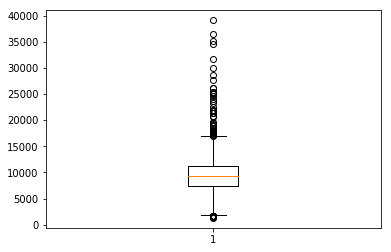

overallqual


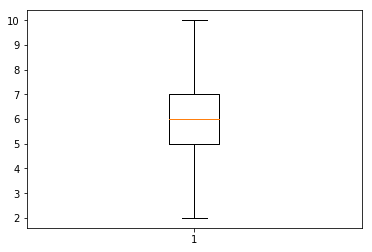

grlivarea


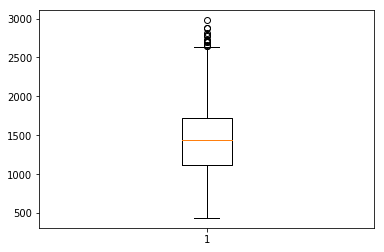

totalbsmtsf


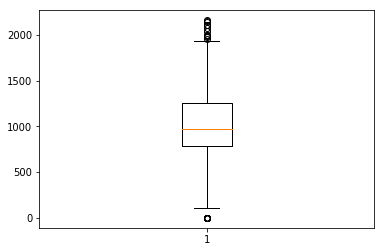

firstflrsf


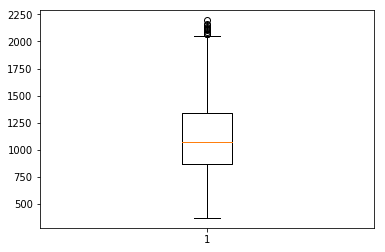

garagecars


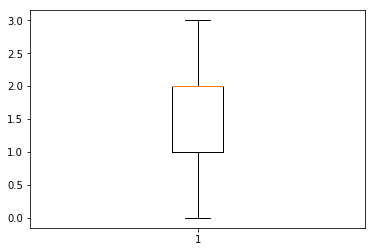

saleprice


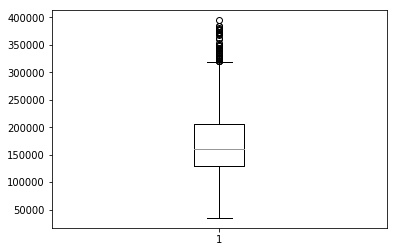

In [83]:
columns = ['lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'saleprice']
for col in columns:
    print(col)
    plt.boxplot(house_df[col])
    plt.show()

In [84]:
house_df = pd.concat([house_df, dummies['salecondition_Partial']], axis = 1)

In [85]:
for col in ['saleprice', 'lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'salecondition_Partial']:
    house_df = house_df.loc[house_df[col].notnull()]
Y = house_df['saleprice']
X = house_df[['lotarea', 'overallqual', 'grlivarea', 'totalbsmtsf', 'firstflrsf', 'garagecars', 'salecondition_Partial']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [86]:
lrm = linear_model.LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8264557082014587
-----Test set statistics-----
R-squared of the model in the test set is: 0.7827943694423598
Mean absolute error of the prediction is: 20608.49473424816
Mean squared error of the prediction is: 756059727.0689415
Root mean squared error of the prediction is: 27496.540274531657
Mean absolute percentage error of the prediction is: 14.131131713062429


In [87]:
from sklearn.linear_model import Ridge

ridgeregr = Ridge(alpha=10**2) 
ridgeregr.fit(X_train, y_train)

y_preds_train = ridgeregr.predict(X_train)
print(y_preds_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

[ 77382.71448805 238402.73078545 216546.53812396 ... 276552.51361643
 132493.06618792 163342.07222064]
R-squared of the model on the training set is: 0.8229895038359734
-----Test set statistics-----
R-squared of the model on the test set is: 0.7928650865771084
Mean absolute error of the prediction is: 20118.859284253806
Mean squared error of the prediction is: 721005094.1446539
Root mean squared error of the prediction is: 26851.53802195796
Mean absolute percentage error of the prediction is: 13.84105152972244


In [88]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**3) 
lassoregr.fit(X_train, y_train)
print(lassoregr.coef_)
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


[1.64128942e+00 2.10450528e+04 4.25566003e+01 3.41472824e+01
 3.35527139e+00 1.24210221e+04 7.25510838e+03]
R-squared of the model on the training set is: 0.822448269565912
-----Test set statistics-----
R-squared of the model on the test set is: 0.793707417365243
Mean absolute error of the prediction is: 20127.083905716197
Mean squared error of the prediction is: 718073068.9289916
Root mean squared error of the prediction is: 26796.885433366908
Mean absolute percentage error of the prediction is: 13.888016428740094


In [89]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**1, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
y_preds_train

R-squared of the model on the training set is: 0.7032308055733032
-----Test set statistics-----
R-squared of the model on the test set is: 0.7024989365500132
Mean absolute error of the prediction is: 23435.67277689736
Mean squared error of the prediction is: 1035555902.7509986
Root mean squared error of the prediction is: 32180.054424301376
Mean absolute percentage error of the prediction is: 15.416649028496836


array([108064.37368711, 201236.27736932, 214132.5848325 , ...,
       245227.06834763, 111356.64740214, 173520.46977896])

In [92]:
house_df['yrsold'].unique()

array([2008., 2007., 2006., 2009., 2010.])

In [98]:
interest_rates = [6.41, 6.34, 6.03, 5.04, 4.69]
inflation_adjusted = [1, 1.03, 1.07, 1.06, 1.08]
i_r = []
i_a = []
for i in house_df.index:
    if(house_df['yrsold'][i] == 2006):
        index = 0
    elif(house_df['yrsold'][i] == 2007):
        index = 1
    elif(house_df['yrsold'][i] == 2008):
        index = 2
    elif(house_df['yrsold'][i] == 2009):
        index = 3
    else:
        index = 4
    i_r.append(interest_rates[index])
    i_a.append(inflation_adjusted[index])
house_df['interest rate'] = i_r
house_df['inflation adjusted'] = i_a

In [102]:
house_df[['saleprice', 'interest rate', 'inflation adjusted']].corr()

,saleprice,interest rate,inflation adjusted
saleprice,1.000000,0.038069,-0.032461
interest rate,0.038069,1.000000,-0.731184
inflation adjusted,-0.032461,-0.731184,1.000000


The best model type is Ridge, and the correlations between saleprice and the interest rates and inflation adjusted value of the dollar at the time of sale 